# Euclidean Alignment + Weighted TL

## Load dataset

In [1]:
import sys

In [2]:
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\plan_c\csp')
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\plan_c\func')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import moabb.datasets
import moabb.paradigms


from copy import deepcopy
from csp.utils import subject_counter
from csp.preprocess import fir_bandpass, apply_bandpass, fetch_left_right_EEG
from csp.preprocess import split_EEG_one_class, process_s_data
from csp.feat_extraction import compute_Z, feat_vector, true_label
from csp.csp import CSP

In [4]:
dframe = pd.DataFrame

In [5]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
ori_data = dict()
mod_data = dict() 

## Load Dataset

In [6]:
# Iter over all data path then store them in sub0X variable
for subj in range(1, 10):
    data_path = '../../datasets/BCICIV2a/A{:02d}T.npz'.format(subj)
    
    # Load EEG data from datapath and store into subj0X variabel then store into ori_dict
    # Then also fetch 's' (EEG data) into mod_data
    ori_data[subj] = np.load(data_path)
    mod_data[subj] = {}
    mod_data[subj]['s'] = deepcopy(ori_data[subj]['s'])
    mod_data[subj]['etyp'] = deepcopy(ori_data[subj]['etyp'])
    mod_data[subj]['epos'] = deepcopy(ori_data[subj]['epos'])
    
    # Remove last three EOG electrodes
    mod_data[subj]['s'] = np.delete(mod_data[subj]['s'], np.s_[22:], 1)

## Preprocessing

### Apply Bandpass Filter

In [7]:
from scipy.signal import firwin, freqs, lfilter

In [8]:
# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

In [9]:
## PREPROCESSING ##

# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

for subj in mod_data.keys():
    temp_raw_EEG = mod_data[subj]['s']
    
    mod_data[subj]['EEG_filtered'] = apply_bandpass(temp_raw_EEG, b)

In [10]:
dframe(mod_data[1]['EEG_filtered']).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.020422,-0.022875,-0.020752,-0.024290,-0.024856,-0.026978,-0.014055,-0.021743,-0.024573,-0.027733,...,-0.025186,-0.022356,-0.023960,-0.029572,-0.028629,-0.025752,-0.020234,-0.024573,-0.024054,-0.019007
1,-0.028404,-0.031205,-0.030831,-0.033074,-0.033981,-0.033931,-0.020491,-0.029673,-0.036051,-0.038065,...,-0.031740,-0.030597,-0.034277,-0.040461,-0.039797,-0.034346,-0.029374,-0.034872,-0.033981,-0.029271
2,-0.022534,-0.027174,-0.026464,-0.029447,-0.028894,-0.029548,-0.017482,-0.027437,-0.032539,-0.034971,...,-0.024285,-0.029289,-0.032084,-0.038319,-0.037874,-0.032493,-0.028467,-0.033443,-0.032392,-0.028682
3,-0.027857,-0.027150,-0.032594,-0.035113,-0.038213,-0.037143,-0.019260,-0.029577,-0.040505,-0.041637,...,-0.035856,-0.031609,-0.039735,-0.045916,-0.046540,-0.041085,-0.032311,-0.039749,-0.039492,-0.030589
4,-0.064138,-0.066045,-0.067683,-0.079740,-0.082914,-0.087771,-0.040368,-0.065460,-0.080927,-0.091818,...,-0.087361,-0.067454,-0.079225,-0.097632,-0.098159,-0.089933,-0.064292,-0.082052,-0.082849,-0.061782


### Convert samples x n_electrodes -> no_trials x n_electrodes x samples 
Remember to process the filtered EEG with shape of samples x electrodes

In [11]:
# Iterate overall all_data
for subj in mod_data.keys():
    print('Processing for subject', subj)
    mod_data[subj]['all_trials'], mod_data[subj]['y'], _ = process_s_data(data=mod_data[subj], eeg_key='EEG_filtered', start_t=0.5, end_t=3.5, fs=250)

Processing for subject 1
Processing for subject 2
Processing for subject 3
Processing for subject 4
Processing for subject 5
Processing for subject 6
Processing for subject 7
Processing for subject 8
Processing for subject 9


In [12]:
mod_data[2]['all_trials'].shape

(144, 22, 750)

In [13]:
dframe(mod_data[5]['all_trials'][6]).iloc[:10]

,0,1,2,3,4,5,6,7,8,9,...,740,741,742,743,744,745,746,747,748,749
0,2.831225,3.908294,4.449849,4.378324,3.742567,2.703605,1.307775,-0.408919,-2.290599,-4.026515,...,-3.934988,-3.078539,-2.011369,-0.861646,0.192806,0.994518,1.429399,1.528896,1.414543,1.317802
1,4.552508,5.900402,6.152449,5.226010,3.403669,1.273342,-0.632542,-1.959919,-2.534516,-2.362089,...,-4.288117,-4.128549,-3.374571,-2.117593,-0.630167,0.755886,1.699310,2.052092,1.845995,1.337277
2,4.040848,5.192079,5.402117,4.672942,3.285968,1.715717,0.279973,-0.873856,-1.699544,-2.192805,...,-5.330225,-4.911525,-4.056859,-2.824312,-1.390331,0.014043,1.130867,1.826411,2.081070,2.069634
3,3.429017,4.367521,4.607730,4.135970,3.124638,1.889428,0.611817,-0.651014,-1.836032,-2.805330,...,-5.934167,-5.142495,-3.934169,-2.513212,-1.105981,0.119408,1.018298,1.584724,1.865963,2.015373
4,3.608418,4.045117,4.080243,3.825804,3.409204,2.922179,2.212409,1.050827,-0.628231,-2.609484,...,-4.718487,-4.275966,-3.733652,-3.069747,-2.261631,-1.279024,-0.158012,1.047967,2.223742,3.281814
5,3.991446,4.108935,3.930405,3.574364,3.110047,2.547555,1.686041,0.297946,-1.609874,-3.700618,...,-3.648237,-3.251446,-2.710506,-2.094913,-1.448670,-0.720658,0.128474,1.159591,2.326735,3.512759
6,3.822723,5.666412,6.340582,5.781415,4.293528,2.477332,0.826080,-0.355372,-0.973503,-1.115745,...,-3.103053,-3.804356,-3.950902,-3.348587,-2.100468,-0.522067,0.955570,2.006688,2.452539,2.364979
7,3.740346,4.855241,5.011246,4.229082,2.809719,1.268153,-0.009607,-0.838442,-1.180222,-1.092079,...,-5.881179,-5.997063,-5.324623,-3.946722,-2.149172,-0.293058,1.224050,2.189421,2.533206,2.405074
8,3.354028,4.185194,4.205664,3.508617,2.399137,1.296841,0.408868,-0.249901,-0.745095,-1.133733,...,-5.957361,-5.987533,-5.491642,-4.454690,-3.001376,-1.341464,0.246939,1.559108,2.456476,2.974979
9,3.062213,3.871230,3.991827,3.514069,2.684576,1.821369,1.027980,0.235331,-0.629816,-1.515984,...,-6.550056,-6.024622,-5.098191,-3.890149,-2.519493,-1.067594,0.341394,1.628959,2.674813,3.423529


## Apply Data Alignment on raw EEG

In [14]:
from func.EA import apply_EA
from func.csp_matlab import csp_feat_ver5

In [15]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 'EEG_filtered', 'all_trials', 'y'])

In [16]:
# Iterate over all subjects to apply EA to all trials
# Define keys to be processed
process_key = ['all_trials']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    mod_data[subj]['all_trials_EA']  = apply_EA(mod_data[subj], process_key)
    print('')

Processing subject  1
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  2
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  3
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  4
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  5
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  6
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  7
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  8
Found 1 key(s) in which EEG data is stored
Computing reference matri

In [17]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 'EEG_filtered', 'all_trials', 'y', 'RefEA', 'R_inv', 'all_trials_EA'])

In [18]:
dframe(mod_data[5]['RefEA']).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,14.328524,11.726248,12.853534,13.460009,13.324563,12.833290,8.599128,10.032622,11.430014,11.947914,...,10.453244,8.978260,10.063086,10.356200,10.591482,10.368370,8.523855,9.091489,8.954617,7.284086
1,11.726248,12.189128,12.068785,12.005063,11.115135,10.704620,9.585176,10.951415,11.183878,11.297983,...,8.661832,9.831772,9.994492,10.134771,9.786477,9.249665,8.773573,8.982710,8.555737,7.341576
2,12.853534,12.068785,12.989954,12.958085,12.559108,11.727079,9.447175,10.933390,12.099687,12.261040,...,9.860789,9.985911,10.896517,10.964286,10.884414,10.363270,9.425194,9.841825,9.485840,8.048208
3,13.460009,12.005063,12.958085,13.901419,13.360468,13.040900,8.743616,10.789745,12.002130,12.983466,...,10.592118,9.933955,10.824847,11.518472,11.488113,11.111100,9.485104,10.103794,9.896453,8.211019
4,13.324563,11.115135,12.559108,13.360468,13.747653,13.403249,8.458048,10.077310,11.778675,12.620037,...,11.486386,9.451242,10.826558,11.346731,11.731168,11.610288,9.476050,10.231591,10.195624,8.422172


In [19]:
# Sanity check that each subject EA data equal to identity matrix
for subj in mod_data.keys():
    all_trials = mod_data[subj]['all_trials_EA']
    all_cov = 0
    
    for tr in all_trials:
        all_cov += np.cov(tr, rowvar=True, ddof=1)
    
    all_cov = all_cov/len(all_trials)
    
    assert np.round(np.diag(all_cov)).sum() == 22
    print('Subject %d OK!' %subj)

Subject 1 OK!
Subject 2 OK!
Subject 3 OK!
Subject 4 OK!
Subject 5 OK!
Subject 6 OK!
Subject 7 OK!
Subject 8 OK!
Subject 9 OK!


# Comparing SVM, SVM_EA, LDA, LDA_EA
Randomized 10 trials 30 times from each subject, then average result.  
For EA approach, also add the features from source subject to build model   
There are four patterns that will be compared for each model
1. **Pattern 1**: train on target training 10 trials_no_EA, test on target test_no_EA
2. **Pattern 2**: train on target training 10 trials EA, test on target test EA (this will not contribute much)  
3. **Pattern 3**: target training trials + source trials without EA  
    training using these trials  
    then test trials to evaluate model (should worsen the model)
4. **Pattern 4**: target training trials first is EA-ed with all source trials, should be 10 + (8 * 144) trials (1162 trials)  
    training using these trials  
    then test trials is EA-ed with training trials of target subject

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

In [21]:
# Prepare data, copy form mod_data
TL_data = {}
TL_data['tgt'] = {}
TL_data['src'] = {}

for subj in mod_data.keys():
    # TARGET
    TL_data['tgt'][subj] = {}
    TL_data['tgt'][subj]['all_trials'] = deepcopy(mod_data[subj]['all_trials'])
    TL_data['tgt'][subj]['all_trials_EA'] = deepcopy(mod_data[subj]['all_trials_EA'])
    TL_data['tgt'][subj]['y'] = deepcopy(mod_data[subj]['y'])    
    
    # SOURCE
    TL_data['src'][subj] = {}
    TL_data['src'][subj]['all_trials'] = deepcopy(mod_data[subj]['all_trials'])
    TL_data['src'][subj]['all_trials_EA'] = deepcopy(mod_data[subj]['all_trials_EA'])
    TL_data['src'][subj]['y'] = deepcopy(mod_data[subj]['y'])    

In [22]:
import random
def svm_lda_EA(data, tgt_subj, n_iter=30, samples_tr=10, key = ['all_trials', 'all_trials_EA'], pattern='pattern1'):
    #pattern = 'pattern1'
    #key = ['all_trials', 'all_trials_EA']
    #tgt_subj = 6
    #data = TL_data
    #n_iter = 30
    #samples_tr = 10

    # ===== TARGET DATA ======
    # Grab the X and y data for pattern1 and pattern 2, use EA data
    if (pattern == 'pattern2') or (pattern == 'pattern4') :
        print('With EA')
        X_tgt = deepcopy(data['tgt'][tgt_subj][key[1]])
    else:
        print('Without EA')
        X_tgt = deepcopy(data['tgt'][tgt_subj][key[0]])

    y_tgt = deepcopy(data['tgt'][tgt_subj]['y'])


    # ====== SOURCE DATA ======
    # Subjects that act as source subject
    sources = [i for i in data['src'].keys() if i != tgt_subj]

    X_src = np.array([])
    y_src = np.array([])
    # Stacking all source subject's X and y trials_EA for pattern 3 and pattern 4 who uses source trials   
    if pattern == 'pattern4' :

        print('Getting sourc trials from subject ', sources)
        print('Stacking trials inside {} key'.format(key[1]))

        for src_subj in sources:
            current_X = deepcopy(data['src'][src_subj][key[1]])
            current_y = deepcopy(data['src'][src_subj]['y'])

            if len(X_src) == 0:
                X_src = current_X
                y_src = current_y
            else :
                X_src = np.concatenate([X_src, current_X], axis=0)
                y_src = np.concatenate([y_src, current_y])   

    elif pattern == 'pattern3' :

        print('Getting source trials from subject ', sources)
        print('Stacking trials inside {} key'.format(key[0]))

        for src_subj in sources:
            current_X = deepcopy(data['src'][src_subj][key[0]])
            current_y = deepcopy(data['src'][src_subj]['y'])

            if len(X_src) == 0:
                X_src = current_X
                y_src = current_y
            else :
                X_src = np.concatenate([X_src, current_X], axis=0)
                y_src = np.concatenate([y_src, current_y])    

    # Sanity check covariance equal 22 (EA) or not (non EA)
    cov = 0

    # Whether all X consist of X_src and X_tgt or only X_tgt
    if (pattern == 'pattern3') or (pattern == 'pattern4') :
        all_X = np.concatenate([X_tgt, X_src])
    else:
        all_X = X_tgt

    # Compute the toal covariance of all X
    for i, tr in enumerate(all_X):
        cov += np.cov(tr, rowvar=True, ddof=1)

    #print(i)
    cov = cov/len(all_X) 

    # EA data diagonal element of total avg cov != 22
    if (pattern == 'pattern2') or (pattern == 'pattern4'): 
        #print(int(np.diag(cov).sum()))
        assert np.round(np.diag(cov).sum()) == 22

    # Non EA data diagonal element total avg cov != 22
    else:
        #print(int(np.diag(cov).sum()))
        assert np.round(np.diag(cov).sum()) != 22

    all_lda = []
    all_svm = []
    
    for i in range(n_iter):
        print(i+1, end=' ')
        ids_train = random.sample(range(len(y_tgt)), samples_tr)

        while (y_tgt[ids_train] == 1).sum() != 5:
            ids_train = random.sample(range(len(y_tgt)), samples_tr)

        assert (y_tgt[ids_train] == 1).sum() == 5

        #print('{}, idx tr trial : {}'.format(i, ids_train))

        ids_test = np.delete(np.arange(0, len(X_tgt)), ids_train)

        XtrRaw = X_tgt[ids_train]
        XteRaw = X_tgt[ids_test]
        ytr = y_tgt[ids_train]
        yte = y_tgt[ids_test]

        if (pattern == 'pattern1') or (pattern == 'pattern2'):
            feat_train, feat_test = csp_feat_ver5(XtrRaw, XteRaw, ytr)

            assert len(feat_train) == len(ytr)
            assert len(feat_test) == len(yte)

        else:
            # Stack the source trials into target test set 
            XteRaw = np.concatenate([X_src, XteRaw], axis=0)

            # Build feature
            feat_train, feat_test = csp_feat_ver5(XtrRaw, XteRaw, ytr)

            # Then grab part of feat test that belongs to X_src and add to feat_train, do this also for ytr
            # NEED TO INVESTIGATE ABOUT THIS
            feat_train = np.concatenate([feat_train, feat_test[:len(X_src)]], axis=0)
            ytr = np.concatenate([ytr, y_src], axis=0)

            # Only grab part of feat_test that is originally XteRaw
            feat_test = feat_test[len(X_src):]


            assert len(feat_train) == len(ytr)
            assert len(feat_test) == len(yte)

            # print(len(ytr))
            # print(len(y_src))
            # print(feat_train.shape)
            # print(feat_test.shape)
            # print(XteRaw.shape)
        
        # Define model, train, and evaluate
        model_lda = LDA()
        model_svm = SVC()

        model_lda.fit(feat_train, ytr)
        model_svm.fit(feat_train, ytr)

        sc_lda = model_lda.score(feat_test, yte)
        sc_svm = model_svm.score(feat_test, yte)

        all_lda.append(sc_lda)
        all_svm.append(sc_svm)

        #print('Iteration {}, score: {:.5f}'.format(i, sc_lda))
        #print(' ')
    
    mean_lda = np.mean(np.array(all_lda))*100
    std_lda = np.std(np.array(all_lda))*100
    mean_svm = np.mean(np.array(all_svm))*100
    std_svm = np.std(np.array(all_svm))*100
    
    print('\nMean accuracy of lda: {:.3f}, svm: {:.3f}'.format(mean_lda, mean_svm))
    
    print('')
    return mean_lda, std_lda, mean_svm, std_svm

In [23]:
pattern = ['pattern1', 'pattern2', 'pattern3', 'pattern4']

for t_subj in TL_data['tgt'].keys():
    print('Processing subject',t_subj)
    for pat in pattern:
        print('Processing ', pat)
        
        TL_data['tgt'][t_subj][pat] = {}
        temp_score = TL_data['tgt'][t_subj][pat]
        temp_score['mean_lda'], temp_score['std_lda'],\
        temp_score['mean_svm'], temp_score['std_svm'] = svm_lda_EA(TL_data, t_subj, n_iter=30, samples_tr=10, key=['all_trials', 'all_trials_EA'], pattern=pat)

Processing subject 1
Processing  pattern1
Without EA
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 69.751, svm: 80.920

Processing  pattern2
With EA
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 70.000, svm: 80.597

Processing  pattern3
Without EA
Getting source trials from subject  [2, 3, 4, 5, 6, 7, 8, 9]
Stacking trials inside all_trials key
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 75.423, svm: 73.557

Processing  pattern4
With EA
Getting sourc trials from subject  [2, 3, 4, 5, 6, 7, 8, 9]
Stacking trials inside all_trials_EA key
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 82.687, svm: 80.871

Processing subject 2
Processing  pattern1
Without EA
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 

In [26]:
TL_data['tgt'][1].keys()

dict_keys(['all_trials', 'all_trials_EA', 'y', 'pattern1', 'pattern2', 'pattern3', 'pattern4'])

In [27]:
pattern = ['pattern1', 'pattern2', 'pattern3', 'pattern4']

for pat in pattern:
    print(' ===== {} ==== '.format(pat))
    print('\t\t\t Score LDA\t Score SVM')
    
    for t_subj in TL_data['tgt'].keys():
        score_svm = TL_data['tgt'][t_subj][pat]['mean_svm']
        #std_svm = TL_data['tgt'][t_subj][pat]['std_svm']
        score_lda = TL_data['tgt'][t_subj][pat]['mean_lda']
        #std_lda = TL_data['tgt'][t_subj][pat]['std_lda']

        print('Subject{:02d} :\t\t {:.3f}\t\t {:.3f} '.format(t_subj, score_lda, score_svm))

 ===== pattern1 ==== 
			 Score LDA	 Score SVM
Subject01 :		 69.751		 80.920 
Subject02 :		 52.587		 52.935 
Subject03 :		 82.239		 90.299 
Subject04 :		 54.552		 57.910 
Subject05 :		 51.542		 51.443 
Subject06 :		 52.736		 55.473 
Subject07 :		 56.567		 60.299 
Subject08 :		 83.930		 93.756 
Subject09 :		 69.701		 77.960 
 ===== pattern2 ==== 
			 Score LDA	 Score SVM
Subject01 :		 70.000		 80.597 
Subject02 :		 53.458		 54.751 
Subject03 :		 82.537		 92.040 
Subject04 :		 55.299		 57.264 
Subject05 :		 50.721		 53.060 
Subject06 :		 53.532		 56.294 
Subject07 :		 55.323		 60.224 
Subject08 :		 84.627		 94.502 
Subject09 :		 68.682		 76.940 
 ===== pattern3 ==== 
			 Score LDA	 Score SVM
Subject01 :		 75.423		 73.557 
Subject02 :		 49.254		 48.010 
Subject03 :		 79.104		 81.741 
Subject04 :		 59.975		 58.308 
Subject05 :		 50.274		 49.826 
Subject06 :		 56.070		 55.075 
Subject07 :		 55.398		 56.418 
Subject08 :		 88.980		 88.731 
Subject09 :		 64.428		 66.318 
 ===== pattern4 ==== 


## Result

In [28]:
# Store each score and std into list
all_sc = {}


# Accessing each pattern
for pat in pattern:
    print('Processing ',pat)
    print('Subject', end=' ')
    all_sc[pat] = {}
    all_sc[pat]['score_lda'] = []
    all_sc[pat]['std_lda'] = []
    all_sc[pat]['score_svm'] = []
    all_sc[pat]['std_svm'] = []

    
    for t_subj in TL_data['tgt'].keys():
        print(t_subj, end = ' ')
        all_sc[pat]['score_lda'].append(TL_data['tgt'][t_subj][pat]['mean_lda'])
        all_sc[pat]['std_lda'].append(TL_data['tgt'][t_subj][pat]['std_lda'])
        all_sc[pat]['score_svm'].append(TL_data['tgt'][t_subj][pat]['mean_svm'])
        all_sc[pat]['std_svm'].append(TL_data['tgt'][t_subj][pat]['std_svm'])
    print('')

Processing  pattern1
Subject 1 2 3 4 5 6 7 8 9 
Processing  pattern2
Subject 1 2 3 4 5 6 7 8 9 
Processing  pattern3
Subject 1 2 3 4 5 6 7 8 9 
Processing  pattern4
Subject 1 2 3 4 5 6 7 8 9 


In [29]:
all_sc['pattern2']['score_lda']

[69.99999999999999,
 53.45771144278607,
 82.53731343283583,
 55.298507462686565,
 50.721393034825866,
 53.53233830845772,
 55.32338308457712,
 84.62686567164181,
 68.68159203980099]

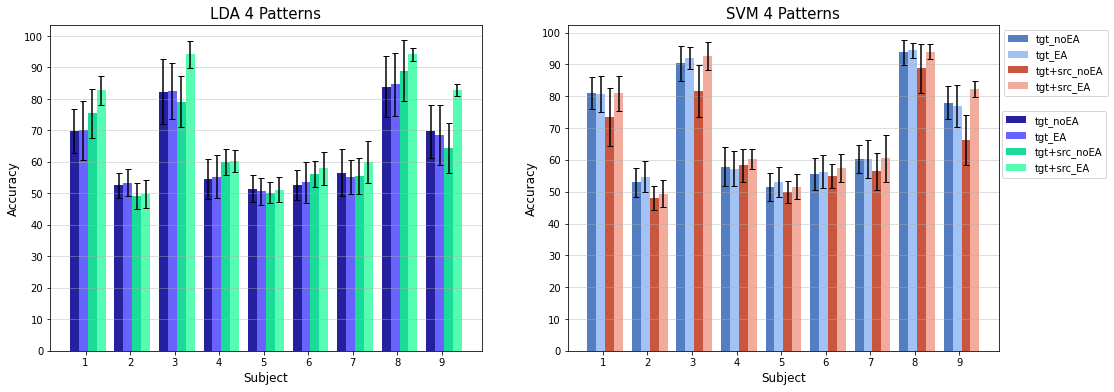

In [30]:
# Position for each subject, adn necessary variables
xpos = np.arange(1, 18, step=2)
w = 0.4
clist1= {
    'pattern1' : '#24209e',
    'pattern2' : '#6863ff',
    'pattern3' : '#1adb98',
    'pattern4' : '#56fcb1'
}

clist2 = {        
    'pattern1' : '#537ec2',
    'pattern2' : '#a2c2f5',
    'pattern3' : '#c95740',
    'pattern4' : '#f2ac9d'
}

label = {
    'pattern1' : 'tgt_noEA',
    'pattern2' : 'tgt_EA',
    'pattern3' : 'tgt+src_noEA',
    'pattern4' : 'tgt+src_EA'

}

# Bar + line plot of LDA result
fig, (lda0, lda1) = plt.subplots(1, 2, figsize=(17, 6))
lda0.set_title('LDA 4 Patterns', fontsize=15)
lda1.set_title('SVM 4 Patterns', fontsize=15)


for i, pat in enumerate(pattern):
    lda0.bar(xpos+w*i, all_sc[pat]['score_lda'], yerr=all_sc[pat]['std_lda'], capsize=3, color=clist1[pat], width=w, label=label[pat])
    lda1.bar(xpos+w*i, all_sc[pat]['score_svm'], yerr=all_sc[pat]['std_svm'], capsize=3, color=clist2[pat], width=w, label=label[pat])

lda0.set_yticks(np.arange(0, 101, step=10))
lda0.set_xticks(xpos+0.5)
lda0.set_xticklabels(np.arange(1, 10))
lda0.set_xlabel('Subject', fontsize=12)
lda0.set_ylabel('Accuracy', fontsize=12)
lda0.grid(axis='y', alpha=0.5)
lda0.legend(bbox_to_anchor=(2.46, 0.75))

lda1.set_yticks(np.arange(0, 101, step=10))
lda1.set_xticks(xpos+0.5)
lda1.set_xticklabels(np.arange(1, 10))
lda1.set_xlabel('Subject', fontsize=12)
lda1.set_ylabel('Accuracy', fontsize=12)
lda1.grid(axis='y', alpha=0.5)
lda1.legend(bbox_to_anchor=(1, 1))

plt.savefig('./img/svm_lda_4pat_bar.png')

# Visualize using T-SNE

In [33]:
from sklearn.manifold import TSNE
from func.csp_matlab import csp_feat_ver3

In [34]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 'EEG_filtered', 'all_trials', 'y', 'RefEA', 'R_inv', 'all_trials_EA'])

In [35]:
data = mod_data

for subj in data.keys():
    # Compute csp feature
    data[subj]['all_feats'] = csp_feat_ver3(data[subj], key='all_trials')
    data[subj]['all_feats_EA'] = csp_feat_ver3(data[subj], key='all_trials_EA')
    
    # Compute sne representation
    data[subj]['sne'] = {}
    data[subj]['sne']['no_EA'] = TSNE().fit_transform(data[subj]['all_feats'])
    data[subj]['sne']['EA'] = TSNE().fit_transform(data[subj]['all_feats_EA'])

In [36]:
import seaborn as sns
palette = np.array(sns.color_palette(n_colors=10))

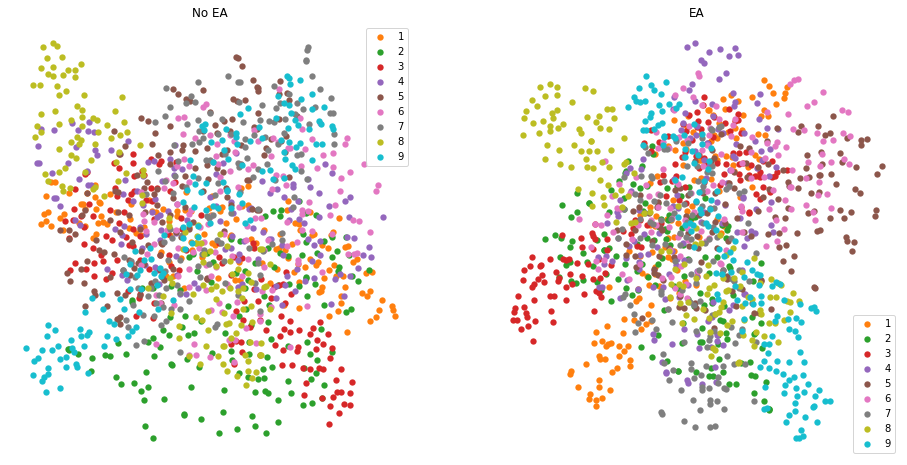

In [37]:
# Distribution of all subjects
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

for subj in mod_data.keys():
    ax0.set_title('No EA')
    ax0.scatter(mod_data[subj]['sne']['no_EA'][:, 0], mod_data[subj]['sne']['no_EA'][:, 1], lw=0, s=40, color=palette[subj], label=subj)
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('EA')
    ax1.scatter(mod_data[subj]['sne']['EA'][:, 0], mod_data[subj]['sne']['EA'][:, 1], lw=0, s=40, color=palette[subj], label=subj)
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

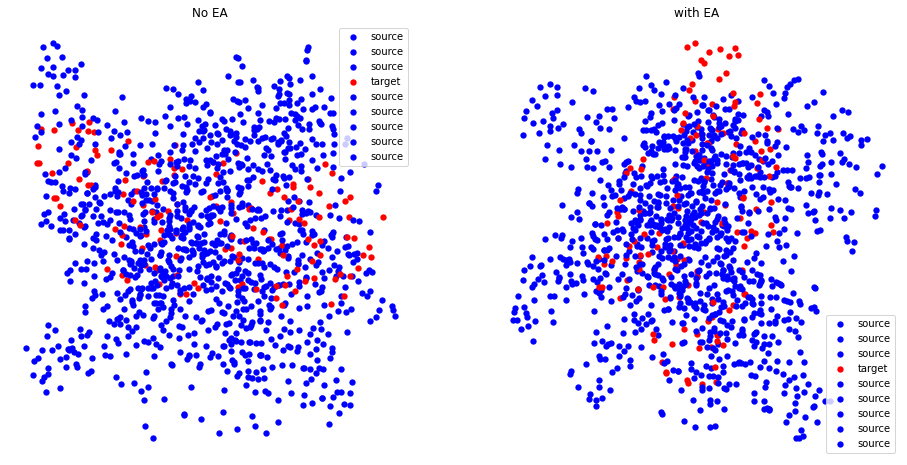

In [38]:
# target vs subject
# Let's set the subject 1 as target
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

colorlist = {
    'tgt' : 'red',
    'src' : 'blue'
}

for subj in mod_data.keys():
    ax0.set_title('No EA')
    tgt_subj = 4
    if subj == tgt_subj:
        ax0.scatter(mod_data[subj]['sne']['no_EA'][:, 0], mod_data[subj]['sne']['no_EA'][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax0.scatter(mod_data[subj]['sne']['no_EA'][:, 0], mod_data[subj]['sne']['no_EA'][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    if subj == tgt_subj:
        ax1.scatter(mod_data[subj]['sne']['EA'][:, 0], mod_data[subj]['sne']['EA'][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax1.scatter(mod_data[subj]['sne']['EA'][:, 0], mod_data[subj]['sne']['EA'][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')
    
plt.savefig('SNE_plot.png')

# EA + (LDA, SVM, wLTL)
In this section, following algorithms/model/approaches will be compared:
1. Subject-specific LDA **(LDA)**
2. Subject-specific SVM **(SVM)**
3. Source + target weighted LTL **(wLTL)**
4. EA, source + target LDA **(EA-LDA)**
5. EA, source + target SVM **(EA-SVM)**
5. EA, source + target wLTL **(EA-wLTL)**

In [39]:
TL_data['tgt'].keys()

dict_keys([1])

In [40]:
# Re-prepare data, redefine TL_data, delete existing content
TL_data = {}
TL_data['tgt'] = {}
TL_data['src'] = {}

for subj in mod_data.keys():
    # TARGET
    TL_data['tgt'][subj] = {}
    TL_data['tgt'][subj]['all_trials'] = deepcopy(mod_data[subj]['all_trials'])
    TL_data['tgt'][subj]['all_trials_EA'] = deepcopy(mod_data[subj]['all_trials_EA'])
    TL_data['tgt'][subj]['y'] = deepcopy(mod_data[subj]['y'])    
    
    # SOURCE
    TL_data['src'][subj] = {}
    TL_data['src'][subj]['all_trials'] = deepcopy(mod_data[subj]['all_trials'])
    TL_data['src'][subj]['all_trials_EA'] = deepcopy(mod_data[subj]['all_trials_EA'])
    TL_data['src'][subj]['all_feats'] = deepcopy(mod_data[subj]['all_feats'])
    TL_data['src'][subj]['all_feats_EA'] = deepcopy(mod_data[subj]['all_feats_EA'])

    TL_data['src'][subj]['y'] = deepcopy(mod_data[subj]['y'])    

## Prepare variables to evaluate wLTL

In [77]:
# Define all necessary function, all of these are imported from weighted-LTL notebook
from sklearn.base import BaseEstimator, ClassifierMixin

class LogReg_TL(BaseEstimator):
    def __init__(self, learningRate=1e-5, num_iter=100, penalty=None, intercept = True,\
                 lambd=1, ETL=np.array([[0, 0],[0, 0]]), mu=0):
        
        self.learningRate = learningRate
        self.num_iter = num_iter
        self.penalty = penalty
        self.intercept = intercept
        self.ETL = ETL
        self.lambd = lambd
        self.mu = mu
        
    def __sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def __logLL(self, z, y):
        return -1 * np.sum((y * np.log10(self.__sigmoid(z))) + ((1 - y) * np.log10(1 - self.__sigmoid(z))))

    def __reg_logLL1(self, z, y, weights):
        reg = 0.5 * self.lambd * np.sum(np.dot(weights, weights))
        
        return (-1 * np.sum((y * np.log10(self.__sigmoid(z))) + ((1 - y) * np.log10(1 - self.__sigmoid(z)))) ) + reg
    
    def __reg_logLL2(self, z, y, weights):
        ETL_det = np.log10(np.linalg.det(self.ETL))
        
        reg = 0.5 * self.lambd * np.sum( ((weights-self.mu)**2)@self.ETL) + ETL_det 

        return (-1 * np.sum((y * np.log10(self.__sigmoid(z))) + ((1 - y) * np.log10(1 - self.__sigmoid(z)))) ) + reg
        
    def fit(self, X_train, y_train):
        self.weights = np.zeros(np.shape(X_train)[1] + 1) 
        
        if self.intercept:
            X_train = np.c_[np.ones([np.shape(X_train)[0], 1]), X_train]
        
        self.costs = []
        
        for i in range(self.num_iter):
            z = np.dot(X_train, self.weights)
            err = -y_train + self.__sigmoid(z)
            
            if self.penalty == 'L1':
                if i == 0:
                    print(self.penalty)
                    
                delta_w = np.dot(err, X_train)

                # weight update
                self.weights += -self.learningRate * delta_w
                self.weights[1:] += -self.learningRate * self.lambd * self.weights[1:]
                
                # costs
                self.costs.append(self.__reg_logLL1(z, y_train, self.weights))
                
            elif (self.penalty == 'L2') and (np.all(self.mu)) :
                if i == 0:
                    print(self.penalty)
                
                delta_w = np.dot(err, X_train)
                
                # weight update
                self.weights += -self.learningRate * delta_w
                self.weights[1:] += -self.learningRate * self.lambd * ((self.weights - self.mu)@self.ETL)[1:]
            
                # cost
                self.costs.append(self.__reg_logLL2(z, y_train, self.weights))
                
            else:
                if i == 0:
                    print(self.penalty)
                    
                delta_w = -self.learningRate * np.dot(err, X_train)
                
                # weight update
                self.weights += delta_w    
                
                # cost
                self.costs.append(self.__logLL(z, y_train))
                
            if i % 30000 == 0:
                print('weights: ',np.round(self.weights, 3))
                
            
        return self
    
    def predict_proba(self, X):
        return self.__sigmoid((X @ self.weights[1:]) + self.weights[0])
        
    def predict(self, X):
        return np.round(self.predict_proba(X))
    
    def score(self, X, y):
        y_pred = self.predict(X)
        scores = ((y==y_pred)*1).mean()
        
        return scores

### Source weights
Compute the clf params $(w_s)$ of each subject when serves as source, model use to train data is:
$$L_1(w_s) = min (\sum_{i=1}^{n_s}H(w_s;y_s^i, x_s^i + \lambda_s||w_s||^2_2)$$

In [78]:
# Use this to build all weights for source data
def build_clf_params(data, key='all_feats'):
    # Where the tranining data is stored
    X = data[key]
    y = data['y']
    
    # Use this model when training subject as source 
    model_L1 = LogReg_TL(learningRate=0.001, num_iter=30000, penalty='L1', lambd=1)
    
    # Fit model and store weight
    model_L1.fit(X, y)
    
    # Return model weights
    return model_L1.weights

In [79]:
# Iterate over all source subject to compute weights
key = 'all_feats'
key_EA = 'all_feats_EA'

for subj in TL_data['src'].keys():
    print('Processing weight subject ', subj)
    print('Processing data inside ', key)
    TL_data['src'][subj]['ws'] = build_clf_params(TL_data['src'][subj], key) 
    
    print('Processing data inside ', key_EA)
    TL_data['src'][subj]['ws_EA'] = build_clf_params(TL_data['src'][subj], key_EA) 
    print('')

Processing weight subject  1
Processing data inside  all_feats
L1
weights:  [ 0.    -0.01  -0.006 -0.002  0.004  0.005  0.008]
Processing data inside  all_feats_EA
L1
weights:  [ 0.    -0.01  -0.006 -0.002  0.004  0.006  0.008]

Processing weight subject  2
Processing data inside  all_feats
L1
weights:  [ 0.    -0.003 -0.002 -0.002  0.002  0.003  0.004]
Processing data inside  all_feats_EA
L1
weights:  [ 0.    -0.003 -0.003 -0.003  0.002  0.003  0.004]

Processing weight subject  3
Processing data inside  all_feats
L1
weights:  [ 0.    -0.015 -0.007 -0.002  0.006  0.009  0.016]
Processing data inside  all_feats_EA
L1
weights:  [ 0.    -0.017 -0.009 -0.003  0.005  0.008  0.014]

Processing weight subject  4
Processing data inside  all_feats
L1
weights:  [ 0.    -0.004 -0.003 -0.002  0.001  0.003  0.004]
Processing data inside  all_feats_EA
L1
weights:  [ 0.    -0.004 -0.003 -0.002  0.001  0.003  0.004]

Processing weight subject  5
Processing data inside  all_feats
L1
weights:  [ 0.    

In [80]:
# Sanity check
for subj in TL_data['src'].keys():
    assert 'ws' in TL_data['src'][subj].keys()

### KL divergence

In [81]:
# First define the kl divergence
def KL_div(P, Q):
    '''
    This KL divergence accepts two distribution P and Q, and compute similarity between them
    '''
    # First convert to np array
    P = np.array(P)
    Q = np.array(Q)
    
    # Then compute their means, datain shape of samples x feat
    mu_P = np.mean(P, axis=0)
    mu_Q = np.mean(Q, axis=0)    
    
    # Compute their covariance
    cov_P = np.cov(P, rowvar=False)
    cov_Q = np.cov(Q, rowvar=False)    
            
    # Use this to prevent KL divergence give NaN values
    cov_P = np.eye(cov_P.shape[0]) * cov_P
    cov_P = np.eye(cov_P.shape[0]) * cov_P
    
    cov_Q_inv = np.linalg.inv(cov_Q)
    
    # Compute KL divergence
    KL_div = np.log(np.linalg.det(cov_Q)/np.linalg.det(cov_P)) - mu_P.shape[0] + np.trace(cov_Q_inv@cov_P) + \
                (mu_P - mu_Q).T@cov_Q_inv@(mu_P - mu_Q)
    
    KL_div = 0.5 * KL_div
    
    return KL_div

In [82]:
# This function will compute similarity using kl div from feat_tgt_tr to one source data 
def kl_div_to_one_source(data, src_subj, feat_tgt_tr, y_tgt_tr, model, key=['all_feats', 'all_feats_EA']):
    '''
    Compute similarity using kl divergence from target feature to one source subject
    
    Parameter:
    data       : data containing target ['tgt'] and source ['src'] data
    src_subj   : current subject to which kl div is measure from target
    feat_tgt_tr: the feature matrix of target subject, 2D array, shape of (samples x features)
    y_tgt_tr   : the label matrix of target subject, 1D array, shape of (features, )
    model      : the current model that is evaluated, right now fill this value either with 'wLTL' or 'EA-wLTL'
    key        : the key in which either non-EA or EA features are stored, defaulted to ['all_feats', 'all_feats_EA']
    
    Return:
    kl_div     : scalar, similarity value between two distribution
    '''
    print('Processing KL div to source subject ', src_subj)
    kl_div_score=[]
    
    # Depends on current model the processed data is different
    if model == 'wLTL':
        key = key[0]
    else:
        key = key[1]

    print('Fetching source data from ', key)

    # Current source subject
    X_src = deepcopy(data['src'][src_subj][key])
    y_src = deepcopy(data['src'][src_subj]['y'])

    # Target data, separate into left and right class
    P_left = feat_tgt_tr[y_tgt_tr == 0]
    P_right = feat_tgt_tr[y_tgt_tr == 1]
    
    # Source data, separate into left and right class
    Q_left = deepcopy(X_src[y_src==0])
    Q_right = deepcopy(X_src[y_src==1])

    
    print('P_left:',P_left.shape)
    print('P_right:',P_right.shape)
    print('Q_left:',Q_left.shape)
    print('Q_right:',Q_right.shape)

    # Compute kl div of each class, average, then append them
    kl_left = KL_div(P_left, Q_left)
    kl_right = KL_div(P_right, Q_right)
    kl_div = (kl_left + kl_right)/2
    kl_div_score.append(kl_div)

    
    return kl_div

### Similarity weights `a_s`

$$a_s = \frac{(1/(KL[d_t, d_s] + \epsilon)^4)}{\sum_{i=1}^m(1/(KL[d_t, d_i] + \epsilon)^4)}$$
  
  where *m* is the number of source

In [83]:
def compute_similarity_weights(kl):
    KL_inv =[]
    eps = 1e-2
    
    for val in kl:
        if val != 0: 
            KL_inv.append(1/(val + eps**4))
        
    a_s = []
    
    for inv_val in KL_inv:
        temp = inv_val/sum(KL_inv)    
        a_s.append(temp)
        
        #print('Similarity weight {:.3f}'.format(temp))
        
    return a_s

### `E_TL` Algorithm
$$\Sigma_{TL} = \frac{diag(\Sigma_{s=1}^m(\alpha_s w_s - \mu_w)(\alpha_s w_s - \mu_w))}{trace(\Sigma_{s=1}^m(\alpha_s w_s - \mu_w)(\alpha_s w_s - \mu_w))}$$
  
While the mean of source weights $\mu_w$ is defined as:
$$\mu_w = \sum_{s=1}^m\alpha_s w_s$$

In [84]:
def compute_ETL(data, a_s, mu_ws, src_subjs, model, key=['ws', 'ws_EA']):
    '''
    Compute the mean of source weights across all subjects
    
    Parameter:
    data      : data containing target and source subject
    a_s       : similarity weights, list, length of all source subjects
    src_subjs : list of subjects currently acting as source, length of all source subjects
    model     : the current model that is evaluated, right now fill this value either with 'wLTL' or 'EA-wLTL'
    key        : the key in which either non-EA or EA features are stored, defaulted to ['all_feats', 'all_feats_EA']
    
    Return:
    mu_ws    : mean of source weights acorss all source subjects, shape of (n_features + 1, )
    '''
    
    if model == 'wLTL':
        key = key[0]
    else:
        key = key[1]
    
    # This will add up all ws - mu_ws, to compute ETL
    all_ws = 0
    for a, s_subj in zip(a_s, src_subjs):
        ws = deepcopy(TL_data['src'][s_subj][key])
        temp_ws = (a*ws - mu_ws)[:, None] @ (a*ws - mu_ws)[None, :]
        all_ws += temp_ws

    # Compute ETL, only contain diagonal element with zero elements to rest of elements
    den = np.diag(temp_ws)
    nom = np.trace(temp_ws)
    ETL = np.diag(den/nom)
    
    return ETL

In [85]:
# Compute mean of source classifier parameters/ weights
def compute_mu_ws(data, a_s, src_subjects, model, key=['ws', 'ws_EA']):
    '''
    Compute the mean of source weights across all subjects
    
    Parameter:
    data     : data containing target and source subject
    a_s      : similarity weights, list, length of all source subjects
    src_subjs: list of subjects currently acting as source, length of all source subjects
    model      : the current model that is evaluated, right now fill this value either with 'wLTL' or 'EA-wLTL'
    
    Return:
    mu_ws    : mean of source weights acorss all source subjects, shape of (n_features + 1, )
    '''
    if model == 'wLTL':
        key = key[0]
    else:
        key = key[1]
    
    print('Fetching source weights from ', key)
    
    all_ws = []
    for a, s_subj in zip(a_s, src_subjects):
        print('Gathering weights from source subject', s_subj)
        ws = deepcopy(TL_data['src'][s_subj][key])
        ws = a * ws
        all_ws.append(ws)

    # Average of ws over all subjects, axis=0
    mu_ws = np.mean(np.array(all_ws), axis=0)    
    
    return mu_ws

### `evaluate_all` function

In [140]:
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import random

def evaluate_all(data, tgt_subj=1, all_keys=['all_trials', 'all_trials_EA', 'y'], n_iter=30, model='wLTL', samples_tr=10):
    '''
    This function will evaluate either one of following six models:
    1. LDA
    2. SVM
    3. wLTL
    4. EA-LDA
    5. EA-SVM
    6. EA-wLTL
    '''
    print('Processing target subject:', tgt_subj)
    print('Evaluate model: ', model)
    
    # Key to define where data is stored
    key_noEA = all_keys[0]
    key_EA = all_keys[1]
    y = all_keys[2]
    
    # =========== PREPROCESSING  ============== #
    '''
    This section will fetch raw target and source data depending on model being evaluated
    '''
    
    # Following models need to grab source EA data
    model_EA = ['EA-LDA', 'EA-SVM', 'EA-wLTL']    
    
    # ===  EA data ===
    if model in model_EA:
        # Set the key to key that contain EA data
        key = key_EA
        
        print('Fetching target data stored in {}'.format(key))
        # Source subjects, exclude current target subject
        
        sources = [s for s in data['src'].keys() if s != tgt_subj]
        
        print('Fetching source data from subjects ', sources)
        print('Stacking source data stored in {}'.format(key))
        
        # Initialize X and y source
        X_src = np.array([])
        y_src = np.array([])
        
        # Iterate over all source subject
        for src_subj in sources:
            current_X = deepcopy(data['src'][src_subj][key])
            current_y = deepcopy(data['src'][src_subj]['y'])

            if len(X_src) == 0:
                X_src = current_X
                y_src = current_y
            else :
                X_src = np.concatenate([X_src, current_X], axis=0)
                y_src = np.concatenate([y_src, current_y]) 
    
    # === no EA ===
    else:
        # Set the key to key that contain non EA data
        key = key_noEA
        print('Fetching target data stored in {}'.format(key))
        
        # Initialize X and y source
        X_src = np.array([])
        y_src = np.array([])
        
        # !! EXCEPTION if model == 'wLTL' grab from non_EA source data 
        if model == 'wLTL':
        # Grab data from the following sources data
            sources = [s for s in data['src'].keys() if s != tgt_subj]
        
            print('Fetching source data from subjects ', sources)
            print('Stacking source data stored in {}'.format(key_noEA))

            # Iterate over all source subject
            for src_subj in sources:
                current_X = deepcopy(data['src'][src_subj][key_noEA])
                current_y = deepcopy(data['src'][src_subj]['y'])

                if len(X_src) == 0:
                    X_src = current_X
                    y_src = current_y
                else :
                    X_src = np.concatenate([X_src, current_X], axis=0)
                    y_src = np.concatenate([y_src, current_y])
        else:
            print('Not fetching data from source')
    
    # Fetch X and y target
    X_tgt = deepcopy(data['tgt'][tgt_subj][key])
    y_tgt = deepcopy(data['tgt'][tgt_subj][y])
    
    # Variable to store all evaluation score
    all_sc = []
        
    # ================ EVALUATION ============== #
    print('Iteration ', end =' ')
    
    # Itern n_ter times to obtain average evaluation score
    for i in range(n_iter):
        
        # Randomly pick samples from target data as training data
        ids_train = random.sample(range(len(y_tgt)), samples_tr)

        # Guarantee balance class in training data
        while (y_tgt[ids_train] == 1).sum() != int(samples_tr/2):
            ids_train = random.sample(range(len(y_tgt)), samples_tr)
        
        assert (y_tgt[ids_train] == 1).sum() == int(samples_tr/2)

        # print('{}, idx tr trial : {}'.format(i+1, ids_train))
        
        # Index of test data
        ids_test = np.delete(np.arange(0, len(X_tgt)), ids_train)
        
        # Split all raw target data into train and test data, shape (trials, n_el, samples) 
        XtrRaw = X_tgt[ids_train]
        XteRaw = X_tgt[ids_test]
        ytr = y_tgt[ids_train]
        yte = y_tgt[ids_test]
        
        # ============ MODEL SELECTION ============= #
        '''
        Different process will be run depending on the model
        '''
        # -------------- LDA/ SVM -------------- #
        if (model == 'LDA') or (model == 'SVM'):
            print('Current model:', model)
            
            # Compute CSP features of target subject
            feat_train, feat_test = csp_feat_ver5(XtrRaw, XteRaw, ytr)

            assert len(feat_train) == len(ytr)
            assert len(feat_test) == len(yte)
            
            print(feat_train.shape)
            print(feat_test.shape)

            if model == 'LDA':
                model_lda = LDA()
                
                # Train model
                _ = model_lda.fit(feat_train, ytr)
                
                # Evaluate on test data
                sc_lda = model_lda.score(feat_test, yte)
                
                # Add to list
                all_sc.append(sc_lda)
                
            elif model == 'SVM':
                model_svm = SVC()
                
                # Train model
                _ = model_svm.fit(feat_train, ytr)
                
                # Evaluate on test data
                sc_svm = model_svm.score(feat_test, yte)
                
                # Add to list
                all_sc.append(sc_svm)
                
        # --------------EA-LDA/ EA-SVM --------------#        
        elif (model == 'EA-LDA') or (model == 'EA-SVM'):
            print('Current model:', model)
            
            # Stack the source trials into target test set 
            XteRaw = np.concatenate([X_src, XteRaw], axis=0)

            # Compute CSP features of target subject
            feat_train, feat_test = csp_feat_ver5(XtrRaw, XteRaw, ytr)

            # Then grab part of feat_test that belongs to X_src and add to feat_train, do this also for ytr (NEED TO INVESTIGATE ABOUT THIS)
            feat_train = np.concatenate([feat_train, feat_test[:len(X_src)]], axis=0)
            ytr = np.concatenate([ytr, y_src], axis=0)

            # Only grab part of feat_test that is originally XteRaw
            feat_test = feat_test[len(X_src):]
                        
            print(feat_train.shape)
            print(feat_test.shape)

            if model == 'EA-LDA':
                model_lda = LDA()
                
                # Train model
                _ = model_lda.fit(feat_train, ytr)
                
                # Evaluate on test data
                sc_lda = model_lda.score(feat_test, yte)
                
                # Add to list
                all_sc.append(sc_lda)
                
            elif model == 'EA-SVM':
                model_svm = SVC()
                
                # Train model
                _ = model_svm.fit(feat_train, ytr)
                
                # Evaluate on test data
                sc_svm = model_svm.score(feat_test, yte)
                
                # Add to list
                all_sc.append(sc_svm)
        
        # --------------wLTL/ EA-wLTL --------------#
        # In case of model == 'wLTL' or model == 'EA-wLTL'
        else: 
            print('Current model:', model)
            
            # Compute targe feat train, feat_test
            feat_train, feat_test = csp_feat_ver5(XtrRaw, XteRaw, ytr)
            
            # Compute ws, kl_div, similarity weights a_s, mu_ws to build ETL
            # 1. KL div to target to respective source subject
            kl_div = []
            for subj in sources:
                kl = kl_div_to_one_source(data, src_subj=subj, feat_tgt_tr=feat_train, y_tgt_tr=ytr, model=model)
                kl_div.append(kl)
            
            # 2. Similarity weights a_s
            a_s = compute_similarity_weights(kl_div)
            
            # 3. Mean of source classifier parameter/ weights (w_s)
            mu_ws = compute_mu_ws(data, a_s, sources, model)
            
            # 4. Compute ETL
            ETL = compute_ETL(data, a_s, mu_ws, sources, model, key=['ws', 'ws_EA'])
            
            # Now define the model, and train it
            model_L2 = LogReg_TL(learningRate=0.001, num_iter=30000, penalty='L2', lambd=1, ETL=ETL, mu=mu_ws)
            
            #print(feat_train.shape)
            #print(ytr.shape)
            
            # Fit model into ten training samples samples
            _ = model_L2.fit(feat_train, ytr)
            
            #print(feat_test.shape)
            #print(yte.shape)
            
            # Evaluate on target test data
            score_wLTL = model_L2.score(feat_test, yte)
            
            # Store into list
            all_sc.append(score_wLTL)
            
        
        
        #print('X_tgt:', X_tgt.shape)
        #print('y_tgt:', y_tgt.shape)
        #print('X_src:', X_src.shape)
        #print('y_src:', y_src.shape)
        #print('feat_train', feat_train.shape)
        #print('feat_test', feat_test.shape)
        #print(model)

        #print('')
        
    print('All iter finished')
    
    mean_sc = np.mean(np.array(all_sc))
    std_sc = np.mean(np.array(all_sc))

    return mean_sc, std_sc

In [142]:
# Define all model to be evaluated
model = ['LDA', 'SVM', 'EA-LDA', 'EA-SVM', 'wLTL', 'EA-wLTL']

all_acc = {}
s_tr = 10

# Iterate over all model
for m in model:
    print('Evaluating', m)
    
    all_acc[m] = {
        'acc' : [],
        'std' : []
    }
    
    # Also iterate over all subjects as target
    for t_subj in TL_data['tgt'].keys():    
        acc, std = evaluate_all(TL_data, tgt_subj=t_subj, all_keys=['all_trials', 'all_trials_EA', 'y'], model=m, n_iter=20, samples_tr=10)
    
        # Store into list
        all_acc[m]['acc'].append(acc)
        all_acc[m]['std'].append(std)
    print(' ')

Evaluating LDA
Processing target subject: 1
Evaluate model:  LDA
Fetching target data stored in all_trials
Not fetching data from source
Iteration  Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
Current model: LDA
(10, 6)
(134, 6)
All iter finished
Processing target subject: 2
Evaluate model:  LDA
Fetching target data stored in all_trials
Not fetching data from

## Misc.

In [143]:
'''PSEUDOCODE
# ======== PREPROCESSING ============ #
# All X are raw EEG signal
If EA-LDA, EA-SVM, EA-wLTL:
    X_source = all source EA trial
    y_source = all source label
    
else:
    No need source data
    
    if wLTL:
        Need source data
        X_source = all source wLTL
        y_source = all source wLTL
        
Also get raw data for target
If EA-LDA, EA-SVM, EA-wLTL:
    X_target = raw data target trial EA
    y_target = label target trial EA
else:
    X_target = raw data target trial
    y_target = label target trial

# ======== EVALUATION ============ #
Iteration for n_iter:
# Each iteration do the following:
    
    # Set index for training and test data
    ids_train = random n_tr_sample
    ids_test = all range of y_target, but remove ids_train
    
    # Divide target into train and test
    Xtr = X_target[ids_train]
    ytr = y_target[ids_train]
    Xte = X_target[ids_test]
    yte = y_test[ids_test]

    # Now evaluate depends on model
    if model is SVM or LDA:
        # Build csp_feat
        feat_tr, feat_te = csp_feat(Xtr, Xte, ytr)
        
        # No source data is used
        model.fit(feat_tr, ytr)
        model.score(feat_te, yte)
    
    elif model is EA-SVM or EA-LDA:
        # Used source EA data to build model
        # Stack X_source and Xte
        Xte = stack([X_source, Xte])
        
        # Build csp_feat
        feat_tr, feat_te = csp_feat(Xtr, Xte, ytr)
        
        # Move over part of feat_te that belongs to X_source to feat_tr
        feat_tr = stack([feat_tr, feat_te[:len(X_source)] ])
        ytr = stack([ytr, y_source])
        
        # Them remove those moved portion from feat_te
        feat_te = feat_te[len(X_source):]
        
        # Train and evaluate model
        model.fit(feat_tr, ytr)
        model.score(feat_te, yte)
        
    elif model is wLTL or EA-wLTL 
        1. csp_feat of target train
        feat_tr, feat_te = csp_feat(Xtr, Xte, ytr)
        all_feats = csp_feat(X_source, y_source)
        
        for s in sources:
            # Iterate over all source
            2. if model = EA-wLTL 
                    feat_source = fetch source csp_feat no EA
                else:
                    feat_source = fetch source csp_feat EA
            
            # We need kl-div, similarity weights a_s, and mu_ws to compute ETL
            2. compute the kl-div, current target to respective subject
            kl_val = kl_div(feat_train, feat_source)

            3. similarity weights a_s
            a_s = similarity_weights(kl_val)

            4. mean of source weights mu_ws
            # ws of each source subject is precomputed separately
            mu_ws = compute_mu_ws(ws of current source subject)
            
            5. compute ETL
            ETL = compute_ETL(a_s, mu_ws)
            
            6. evaluate model
            model = model_LTL(ETL=ETL, mu=mu_ws)
            model.fit(feat_tr, ytr)
            model.score(feat_te, yte)
'''

'PSEUDOCODE\n# ======== PREPROCESSING ============ #\n# All X are raw EEG signal\nIf EA-LDA, EA-SVM, EA-wLTL:\n    X_source = all source EA trial\n    y_source = all source label\n    \nelse:\n    No need source data\n    \n    if wLTL:\n        Need source data\n        X_source = all source wLTL\n        y_source = all source wLTL\n        \nAlso get raw data for target\nIf EA-LDA, EA-SVM, EA-wLTL:\n    X_target = raw data target trial EA\n    y_target = label target trial EA\nelse:\n    X_target = raw data target trial\n    y_target = label target trial\n\n# ======== EVALUATION ============ #\nIteration for n_iter:\n# Each iteration do the following:\n    \n    # Set index for training and test data\n    ids_train = random n_tr_sample\n    ids_test = all range of y_target, but remove ids_train\n    \n    # Divide target into train and test\n    Xtr = X_target[ids_train]\n    ytr = y_target[ids_train]\n    Xte = X_target[ids_test]\n    yte = y_test[ids_test]\n\n    # Now evaluate dep

## Result

## Accuracy with 